In [15]:
data_dir = "data/animais"

In [16]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Imagens Originais


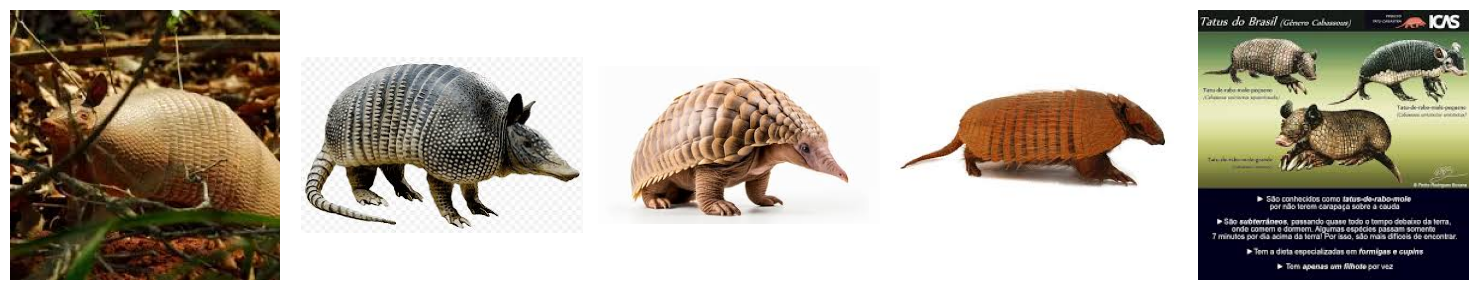

Após RandomResizedCrop


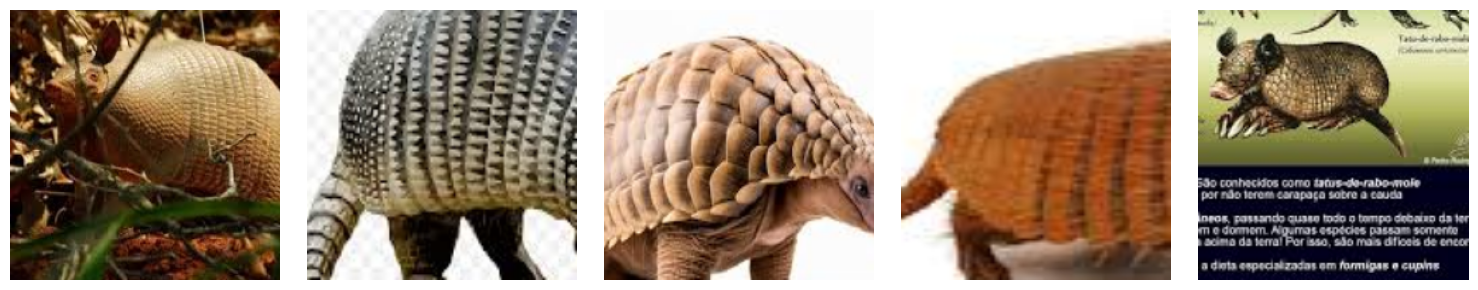

Após RandomHorizontalFlip


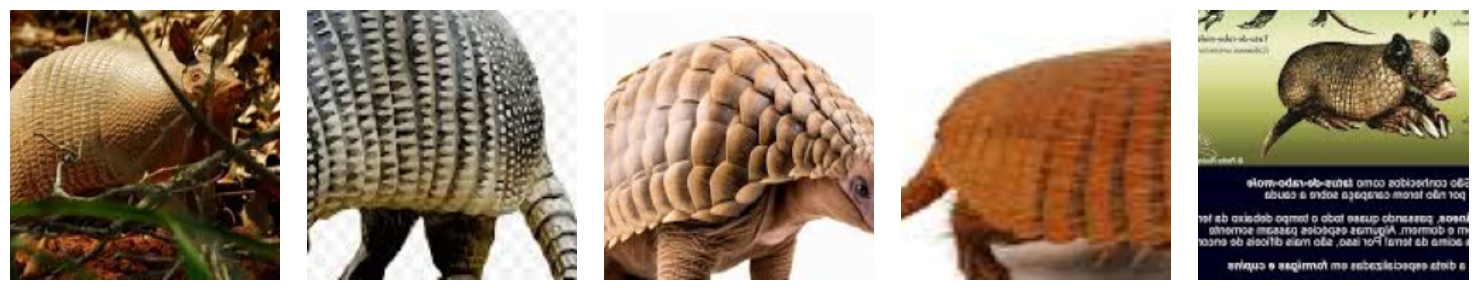

Após RandomRotation


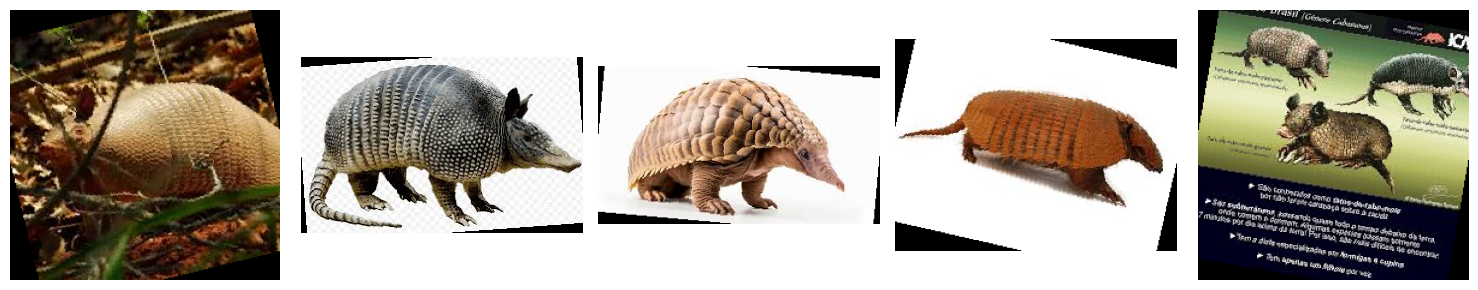

Após RandomAffine


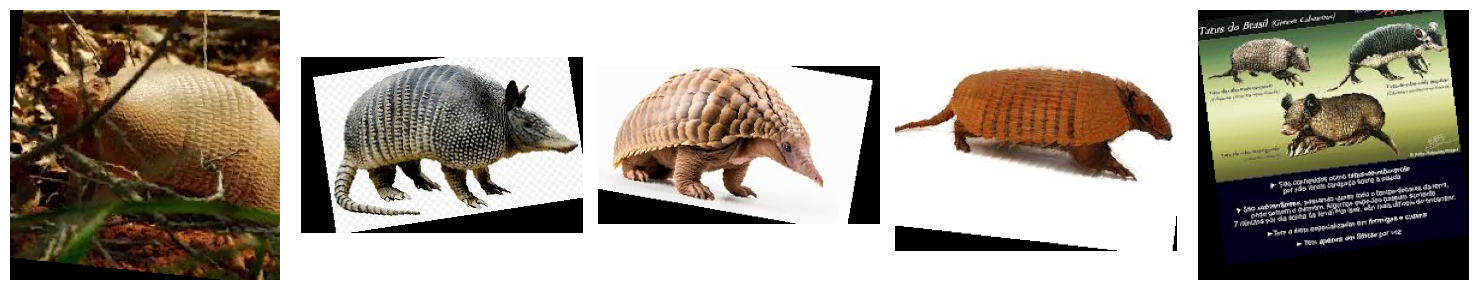

In [19]:
example_dir = os.path.join(data_dir, 'train')
example_set = datasets.ImageFolder(example_dir, transform=None)
example_images = [example_set[i][0] for i in random.sample(range(len(example_set)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de RandomResizedCrop
cropped_images = [transforms.RandomResizedCrop(224)(img) for img in example_images]
print("Após RandomResizedCrop")
show_images(cropped_images)

# Exemplo de RandomHorizontalFlip
flipped_images = [transforms.RandomHorizontalFlip()(img) for img in cropped_images]
print("Após RandomHorizontalFlip")
show_images(flipped_images)

# Exemplo de RandomRotation
rotated_images = [transforms.RandomRotation(15)(img) for img in example_images]
print("Após RandomRotation")
show_images(rotated_images)

# Exemplo de RandomAffine
affined_images = [transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img) for img in example_images]
print("Após RandomAffine")
show_images(affined_images)

In [20]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transform_aug = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 32 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([1, 2])


100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


Epoch 1, Train Loss: 0.788, Train Accuracy: 14.89%
Epoch 1, Val Loss: 0.689, Val Accuracy: 56.56%


100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


Epoch 2, Train Loss: 0.658, Train Accuracy: 63.83%
Epoch 2, Val Loss: 0.738, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


Epoch 3, Train Loss: 0.531, Train Accuracy: 85.11%
Epoch 3, Val Loss: 0.829, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


Epoch 4, Train Loss: 0.466, Train Accuracy: 85.11%
Epoch 4, Val Loss: 0.945, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


Epoch 5, Train Loss: 0.439, Train Accuracy: 85.11%
Epoch 5, Val Loss: 1.042, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


Epoch 6, Train Loss: 0.428, Train Accuracy: 85.11%
Epoch 6, Val Loss: 1.098, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


Epoch 7, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 7, Val Loss: 1.128, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


Epoch 8, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 8, Val Loss: 1.159, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


Epoch 9, Train Loss: 0.428, Train Accuracy: 85.11%
Epoch 9, Val Loss: 1.185, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


Epoch 10, Train Loss: 0.401, Train Accuracy: 85.11%
Epoch 10, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


Epoch 11, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 11, Val Loss: 1.171, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.18it/s]


Epoch 12, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 12, Val Loss: 1.154, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.68it/s]


Epoch 13, Train Loss: 0.412, Train Accuracy: 85.11%
Epoch 13, Val Loss: 1.162, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.85it/s]


Epoch 14, Train Loss: 0.412, Train Accuracy: 85.11%
Epoch 14, Val Loss: 1.166, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.62it/s]


Epoch 15, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 15, Val Loss: 1.174, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.35it/s]


Epoch 16, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 16, Val Loss: 1.159, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.49it/s]


Epoch 17, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 17, Val Loss: 1.148, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


Epoch 18, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 18, Val Loss: 1.151, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


Epoch 19, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 19, Val Loss: 1.132, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


Epoch 20, Train Loss: 0.437, Train Accuracy: 85.11%
Epoch 20, Val Loss: 1.135, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.61it/s]


Epoch 21, Train Loss: 0.463, Train Accuracy: 85.11%
Epoch 21, Val Loss: 1.125, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


Epoch 22, Train Loss: 0.437, Train Accuracy: 85.11%
Epoch 22, Val Loss: 1.119, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Epoch 23, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 23, Val Loss: 1.107, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.62it/s]


Epoch 24, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 24, Val Loss: 1.123, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.67it/s]


Epoch 25, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 25, Val Loss: 1.126, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


Epoch 26, Train Loss: 0.411, Train Accuracy: 85.11%
Epoch 26, Val Loss: 1.125, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.86it/s]


Epoch 27, Train Loss: 0.437, Train Accuracy: 85.11%
Epoch 27, Val Loss: 1.128, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.70it/s]


Epoch 28, Train Loss: 0.411, Train Accuracy: 85.11%
Epoch 28, Val Loss: 1.142, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.60it/s]


Epoch 29, Train Loss: 0.411, Train Accuracy: 85.11%
Epoch 29, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


Epoch 30, Train Loss: 0.423, Train Accuracy: 85.11%
Epoch 30, Val Loss: 1.145, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.88it/s]


Epoch 31, Train Loss: 0.410, Train Accuracy: 85.11%
Epoch 31, Val Loss: 1.145, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


Epoch 32, Train Loss: 0.410, Train Accuracy: 85.11%
Epoch 32, Val Loss: 1.140, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.35it/s]


Epoch 33, Train Loss: 0.423, Train Accuracy: 85.11%
Epoch 33, Val Loss: 1.166, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


Epoch 34, Train Loss: 0.410, Train Accuracy: 85.11%
Epoch 34, Val Loss: 1.148, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.85it/s]


Epoch 35, Train Loss: 0.435, Train Accuracy: 85.11%
Epoch 35, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.65it/s]


Epoch 36, Train Loss: 0.422, Train Accuracy: 85.11%
Epoch 36, Val Loss: 1.146, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


Epoch 37, Train Loss: 0.433, Train Accuracy: 85.11%
Epoch 37, Val Loss: 1.138, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.95it/s]


Epoch 38, Train Loss: 0.420, Train Accuracy: 85.11%
Epoch 38, Val Loss: 1.125, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


Epoch 39, Train Loss: 0.394, Train Accuracy: 85.11%
Epoch 39, Val Loss: 1.126, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.38it/s]


Epoch 40, Train Loss: 0.419, Train Accuracy: 85.11%
Epoch 40, Val Loss: 1.160, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.53it/s]


Epoch 41, Train Loss: 0.456, Train Accuracy: 85.11%
Epoch 41, Val Loss: 1.135, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Epoch 42, Train Loss: 0.428, Train Accuracy: 85.11%
Epoch 42, Val Loss: 1.124, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.27it/s]


Epoch 43, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 43, Val Loss: 1.110, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.46it/s]


Epoch 44, Train Loss: 0.387, Train Accuracy: 85.11%
Epoch 44, Val Loss: 1.102, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


Epoch 45, Train Loss: 0.409, Train Accuracy: 85.11%
Epoch 45, Val Loss: 1.185, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.18it/s]


Epoch 46, Train Loss: 0.411, Train Accuracy: 85.11%
Epoch 46, Val Loss: 1.127, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  8.66it/s]


Epoch 47, Train Loss: 0.399, Train Accuracy: 85.11%
Epoch 47, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.57it/s]


Epoch 48, Train Loss: 0.383, Train Accuracy: 85.11%
Epoch 48, Val Loss: 1.087, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Epoch 49, Train Loss: 0.405, Train Accuracy: 85.11%
Epoch 49, Val Loss: 1.169, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.64it/s]


Epoch 50, Train Loss: 0.390, Train Accuracy: 85.11%
Epoch 50, Val Loss: 0.975, Val Accuracy: 43.44%
Treinamento concluído


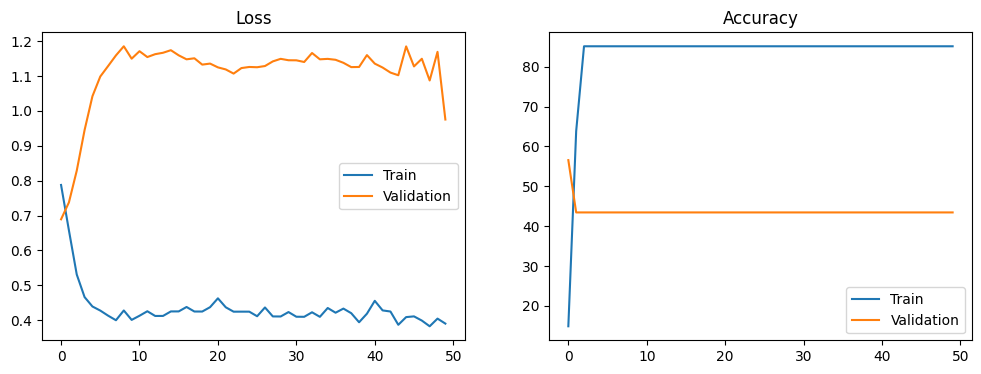

In [22]:
model_no_aug = CNN(num_classes=2).to(device)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.01, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=50)

plot_history(history_no_aug)

100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


Epoch 1, Train Loss: 0.642, Train Accuracy: 85.11%
Epoch 1, Val Loss: 0.734, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.56it/s]


Epoch 2, Train Loss: 0.552, Train Accuracy: 85.11%
Epoch 2, Val Loss: 0.831, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


Epoch 3, Train Loss: 0.460, Train Accuracy: 85.11%
Epoch 3, Val Loss: 1.056, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


Epoch 4, Train Loss: 0.478, Train Accuracy: 85.11%
Epoch 4, Val Loss: 1.247, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.30it/s]


Epoch 5, Train Loss: 0.431, Train Accuracy: 85.11%
Epoch 5, Val Loss: 1.068, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.38it/s]


Epoch 6, Train Loss: 0.419, Train Accuracy: 85.11%
Epoch 6, Val Loss: 1.085, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.39it/s]


Epoch 7, Train Loss: 0.414, Train Accuracy: 85.11%
Epoch 7, Val Loss: 1.150, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


Epoch 8, Train Loss: 0.460, Train Accuracy: 85.11%
Epoch 8, Val Loss: 1.221, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Epoch 9, Train Loss: 0.446, Train Accuracy: 85.11%
Epoch 9, Val Loss: 1.078, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


Epoch 10, Train Loss: 0.427, Train Accuracy: 85.11%
Epoch 10, Val Loss: 1.065, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


Epoch 11, Train Loss: 0.404, Train Accuracy: 85.11%
Epoch 11, Val Loss: 1.092, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


Epoch 12, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 12, Val Loss: 1.130, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


Epoch 13, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 13, Val Loss: 1.159, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


Epoch 14, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 14, Val Loss: 1.177, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


Epoch 15, Train Loss: 0.452, Train Accuracy: 85.11%
Epoch 15, Val Loss: 1.174, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


Epoch 16, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 16, Val Loss: 1.130, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.37it/s]


Epoch 17, Train Loss: 0.424, Train Accuracy: 85.11%
Epoch 17, Val Loss: 1.127, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


Epoch 18, Train Loss: 0.437, Train Accuracy: 85.11%
Epoch 18, Val Loss: 1.140, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


Epoch 19, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 19, Val Loss: 1.125, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


Epoch 20, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 20, Val Loss: 1.154, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


Epoch 21, Train Loss: 0.436, Train Accuracy: 85.11%
Epoch 21, Val Loss: 1.121, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


Epoch 22, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 22, Val Loss: 1.118, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


Epoch 23, Train Loss: 0.423, Train Accuracy: 85.11%
Epoch 23, Val Loss: 1.121, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


Epoch 24, Train Loss: 0.423, Train Accuracy: 85.11%
Epoch 24, Val Loss: 1.136, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.26it/s]


Epoch 25, Train Loss: 0.408, Train Accuracy: 85.11%
Epoch 25, Val Loss: 1.163, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


Epoch 26, Train Loss: 0.436, Train Accuracy: 85.11%
Epoch 26, Val Loss: 1.159, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


Epoch 27, Train Loss: 0.420, Train Accuracy: 85.11%
Epoch 27, Val Loss: 1.130, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.36it/s]


Epoch 28, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 28, Val Loss: 1.128, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.04it/s]


Epoch 29, Train Loss: 0.423, Train Accuracy: 85.11%
Epoch 29, Val Loss: 1.134, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


Epoch 30, Train Loss: 0.419, Train Accuracy: 85.11%
Epoch 30, Val Loss: 1.110, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


Epoch 31, Train Loss: 0.453, Train Accuracy: 85.11%
Epoch 31, Val Loss: 1.145, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


Epoch 32, Train Loss: 0.422, Train Accuracy: 85.11%
Epoch 32, Val Loss: 1.081, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.35it/s]


Epoch 33, Train Loss: 0.407, Train Accuracy: 85.11%
Epoch 33, Val Loss: 1.108, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


Epoch 34, Train Loss: 0.422, Train Accuracy: 85.11%
Epoch 34, Val Loss: 1.160, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.30it/s]


Epoch 35, Train Loss: 0.407, Train Accuracy: 85.11%
Epoch 35, Val Loss: 1.141, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.54it/s]


Epoch 36, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 36, Val Loss: 1.145, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


Epoch 37, Train Loss: 0.416, Train Accuracy: 85.11%
Epoch 37, Val Loss: 1.142, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


Epoch 38, Train Loss: 0.416, Train Accuracy: 85.11%
Epoch 38, Val Loss: 1.134, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


Epoch 39, Train Loss: 0.399, Train Accuracy: 85.11%
Epoch 39, Val Loss: 1.148, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


Epoch 40, Train Loss: 0.419, Train Accuracy: 85.11%
Epoch 40, Val Loss: 1.161, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Epoch 41, Train Loss: 0.429, Train Accuracy: 85.11%
Epoch 41, Val Loss: 1.092, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.18it/s]


Epoch 42, Train Loss: 0.398, Train Accuracy: 85.11%
Epoch 42, Val Loss: 1.083, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


Epoch 43, Train Loss: 0.416, Train Accuracy: 85.11%
Epoch 43, Val Loss: 1.178, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


Epoch 44, Train Loss: 0.404, Train Accuracy: 85.11%
Epoch 44, Val Loss: 1.130, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


Epoch 45, Train Loss: 0.393, Train Accuracy: 85.11%
Epoch 45, Val Loss: 1.118, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


Epoch 46, Train Loss: 0.414, Train Accuracy: 85.11%
Epoch 46, Val Loss: 1.140, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  9.81it/s]


Epoch 47, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 47, Val Loss: 1.124, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00,  8.38it/s]


Epoch 48, Train Loss: 0.401, Train Accuracy: 85.11%
Epoch 48, Val Loss: 1.073, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


Epoch 49, Train Loss: 0.391, Train Accuracy: 85.11%
Epoch 49, Val Loss: 1.268, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:00<00:00, 11.14it/s]


Epoch 50, Train Loss: 0.461, Train Accuracy: 85.11%
Epoch 50, Val Loss: 1.083, Val Accuracy: 43.44%
Treinamento concluído


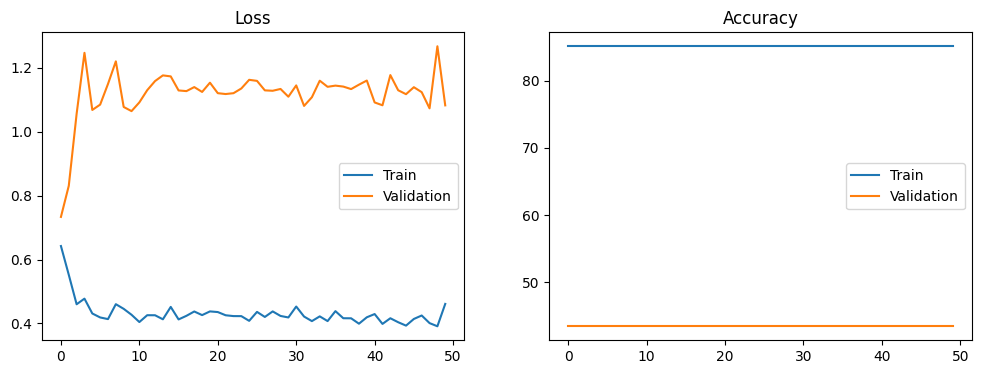

In [23]:
model_aug = CNN(num_classes=2).to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=50)

plot_history(history_aug)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


Epoch 1, Train Loss: 0.628, Train Accuracy: 85.11%
Epoch 1, Val Loss: 0.729, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:01<00:00,  4.07it/s]


Epoch 2, Train Loss: 0.537, Train Accuracy: 85.11%
Epoch 2, Val Loss: 0.808, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]


Epoch 3, Train Loss: 0.478, Train Accuracy: 85.11%
Epoch 3, Val Loss: 0.931, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 4, Train Loss: 0.419, Train Accuracy: 85.11%
Epoch 4, Val Loss: 1.055, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Epoch 5, Train Loss: 0.416, Train Accuracy: 85.11%
Epoch 5, Val Loss: 1.163, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  4.00it/s]


Epoch 6, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 6, Val Loss: 1.198, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


Epoch 7, Train Loss: 0.401, Train Accuracy: 85.11%
Epoch 7, Val Loss: 1.194, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 8, Train Loss: 0.428, Train Accuracy: 85.11%
Epoch 8, Val Loss: 1.197, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.43it/s]


Epoch 9, Train Loss: 0.427, Train Accuracy: 85.11%
Epoch 9, Val Loss: 1.168, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.43it/s]


Epoch 10, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 10, Val Loss: 1.158, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Epoch 11, Train Loss: 0.414, Train Accuracy: 85.11%
Epoch 11, Val Loss: 1.158, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 12, Train Loss: 0.414, Train Accuracy: 85.11%
Epoch 12, Val Loss: 1.146, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


Epoch 13, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 13, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 14, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 14, Val Loss: 1.178, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch 15, Train Loss: 0.427, Train Accuracy: 85.11%
Epoch 15, Val Loss: 1.163, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


Epoch 16, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 16, Val Loss: 1.172, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.40it/s]


Epoch 17, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 17, Val Loss: 1.150, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 18, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 18, Val Loss: 1.165, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.48it/s]


Epoch 19, Train Loss: 0.427, Train Accuracy: 85.11%
Epoch 19, Val Loss: 1.143, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Epoch 20, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 20, Val Loss: 1.148, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


Epoch 21, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 21, Val Loss: 1.144, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 22, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 22, Val Loss: 1.161, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 23, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 23, Val Loss: 1.151, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch 24, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 24, Val Loss: 1.126, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Epoch 25, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 25, Val Loss: 1.130, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch 26, Train Loss: 0.464, Train Accuracy: 85.11%
Epoch 26, Val Loss: 1.135, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


Epoch 27, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 27, Val Loss: 1.119, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


Epoch 28, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 28, Val Loss: 1.135, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.51it/s]


Epoch 29, Train Loss: 0.439, Train Accuracy: 85.11%
Epoch 29, Val Loss: 1.141, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 30, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 30, Val Loss: 1.123, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


Epoch 31, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 31, Val Loss: 1.142, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 32, Train Loss: 0.439, Train Accuracy: 85.11%
Epoch 32, Val Loss: 1.126, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.48it/s]


Epoch 33, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 33, Val Loss: 1.136, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch 34, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 34, Val Loss: 1.133, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


Epoch 35, Train Loss: 0.400, Train Accuracy: 85.11%
Epoch 35, Val Loss: 1.136, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


Epoch 36, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 36, Val Loss: 1.161, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 37, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 37, Val Loss: 1.149, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


Epoch 38, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 38, Val Loss: 1.161, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


Epoch 39, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 39, Val Loss: 1.156, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.28it/s]


Epoch 40, Train Loss: 0.412, Train Accuracy: 85.11%
Epoch 40, Val Loss: 1.166, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch 41, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 41, Val Loss: 1.151, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Epoch 42, Train Loss: 0.412, Train Accuracy: 85.11%
Epoch 42, Val Loss: 1.142, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


Epoch 43, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 43, Val Loss: 1.152, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.33it/s]


Epoch 44, Train Loss: 0.439, Train Accuracy: 85.11%
Epoch 44, Val Loss: 1.151, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


Epoch 45, Train Loss: 0.399, Train Accuracy: 85.11%
Epoch 45, Val Loss: 1.142, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 46, Train Loss: 0.425, Train Accuracy: 85.11%
Epoch 46, Val Loss: 1.147, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


Epoch 47, Train Loss: 0.426, Train Accuracy: 85.11%
Epoch 47, Val Loss: 1.162, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 48, Train Loss: 0.413, Train Accuracy: 85.11%
Epoch 48, Val Loss: 1.151, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 49, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 49, Val Loss: 1.146, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch 50, Train Loss: 0.438, Train Accuracy: 85.11%
Epoch 50, Val Loss: 1.125, Val Accuracy: 43.44%
Treinamento concluído


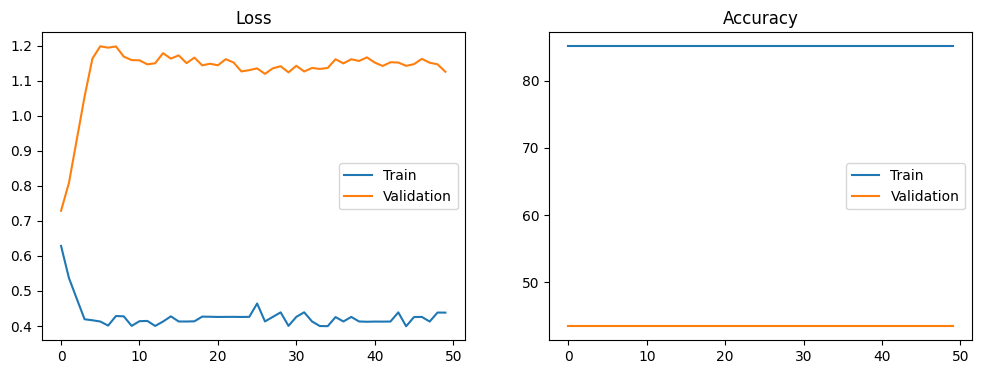

In [25]:
transform_aug_v2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Nova transformação
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Nova transformação
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Nova transformação
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Recarregando o conjunto de dados com as novas transformações
train_set_aug_v2 = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_v2)

train_loader_aug_v2 = DataLoader(train_set_aug_v2, batch_size=32, shuffle=True)

# Treinando o modelo com o novo conjunto de transformações
model_aug_v2 = CNN(num_classes=2).to(device)

criterion_aug_v2 = nn.CrossEntropyLoss()
optimizer_aug_v2 = optim.SGD(model_aug_v2.parameters(), lr=0.01, momentum=0.9)

history_aug_v2 = train_model(model_aug_v2, train_loader_aug_v2, val_loader, criterion_aug_v2, optimizer_aug_v2, device, num_epochs=50)

# Plotando o histórico do novo treinamento
plot_history(history_aug_v2)



RandomVerticalFlip(): Realiza uma inversão vertical aleatória das imagens com uma probabilidade de 50%. Isso ajuda a aumentar a diversidade da base de treinamento, especialmente para imagens de objetos que podem ser invertidos verticalmente.


ColorJitter(): Ajuste aleatório de brilho, contraste, saturação e matiz. Isso permite simular variações de iluminação e condições de captura, o que pode tornar o modelo mais robusto a mudanças nas condições do ambiente.


RandomAffine(): Aplica uma transformação afim aleatória, que pode envolver rotação, translação (deslocamento) e escala. Isso ajuda o modelo a aprender invariâncias a essas transformações, o que é útil para objetos que podem aparecer em diferentes posições e orientações.